In [2]:
# Necessary imports
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from active_tester import ActiveTester

import numpy as np
import seaborn as sns
import pandas as pd
from active_tester.estimators.naive import Naive
from active_tester.estimators.learned import Learned
from active_tester.query_strategy.random import Random
from active_tester.query_strategy.noisy_label_uncertainty import LabelUncertainty
from active_tester.query_strategy.classifier_uncertainty import ClassifierUncertainty
from active_tester.query_strategy.dpp import DPP
from active_tester.query_strategy.prototypical import Prototypical

from sklearn.metrics import accuracy_score
from active_tester.label_estimation.methods import oracle_one_label, no_oracle, oracle_multiple_labels

## Prototypical Vetting
Given a low-dimensional embedding of the data, the idea of prototypical vetting is to estimate a "prototype" member for each class in the embedding space and then to pick a batch of new points to vet that are either close to the prototypes (reinforce the notion) or far away (adjust the model).  This idea was inspired by __[Prototypical Networks for Few-shot Learning](https://arxiv.org/abs/1703.05175)__.

Note that the strategy requires an embedding of the data.  In this implementation, we assume the underlying model is a tensorflow model and that one of the layers can serve as the embedding.

The prototypical query strategy proceeds in two basic steps:
* Initialization.  First, we try to select a small number of examples from each class.  We require at least `min_examples` items from each class.  These initial examples are chosen at random from the `min_examples * sample_window` items in which the classifier is most confident.
* Selection based on prototypes.  Once we have enough initial examples, we compute the prototype for each class.  The prototype for a class is a weighted average of the vetted items assigned to that class and the unvetted items predicted to be in that class.  Then, we compute the Euclidean distance from each unvetted item to each prototype.  Then, we select the `batch_size / 2` items closest to the prototypes and the `batch_size / 2` items farthest from any of the prototypes.  Recall that `batch_size` is a parameter of the `query_vetted` method.  Then, we iteratively update the prototypes and distances and select batches of items to vet.

## Parameters

Unlike some of our other vetting strategies, prototypical has a few parameters that need to be set. 
* `weights`: default=[.6,.2,.2], The weights determine how the prototypes are updated after each batch is vetted.  The first entry of the list is the weight applied to the vetted items, the second is the weight applied to the previous prototypes, and the third is the weight applied to the model's prediction for the unvetted items.
* `min_examples`: default=5, the minimum number of examples for each class needed to initilize strategy.  We vet the items with the highest model confidence for each class, until the number of desired examples is reached for each class.
* `sample_window`: default=2, this number is multiplied by the min_examples to give E potential examples to vet during the initializing steps. Min is 2.
* `use_unvetted`: default=False, whether to use the models predictions in making the prototypes.  If false the weight for those will be set to 0.

Note that `min_examples` x (number of classes) should be less than or equal to the total budget, else we may never got out of the initialization phase.

While this strategy works well with the Naive estimator, we recommend using it with the Learned estimator with the `use_features` parameter set to `True`, as the points it vets are distributed unevenly in the embedding space.

## Example

In the cells below, we will build a classifier to evaluate and then apply active testing with the prototypical query strategy.

We first load the dataset.  Note that this cell will download the cifar10 dataset, if you do not already have it.

In [3]:
## Load training data
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

Next, we create a set of noisy labels

In [4]:
def create_noisy_labels(ground_truth, prob, num_classes, rows):
    labels = np.random.randint(0,num_classes, (rows, 1))
    available_indices = np.arange(len(labels))
    indices = np.random.choice(available_indices, int(rows * prob), replace=False)
    
    for index in indices:
        labels[index] = ground_truth[index]
        
    return labels

X = test_images
Y_ground_truth = test_labels.flatten()
Y_noisy = np.hstack(((create_noisy_labels(Y_ground_truth, 0.75, len(class_names), len(X)),
                    create_noisy_labels(Y_ground_truth, 0.5, len(class_names), len(X)),
                    create_noisy_labels(Y_ground_truth, 0.25, len(class_names), len(X)))))

We then define a ProtoNet layer, based on the paper cited above.  We will use this as the final layer in the neural network classifier we evaluate below.  Note that this layer is not necessary to use the prototypical query strategy.

In [5]:
class ProtoNet(tf.keras.layers.Layer):
    def __init__(self,learned_prototypes=100,embed_size=200,max_way=16,dist_metric='euclidean',pre_trained=None):
        super(ProtoNet,self).__init__()
        self.learned_prototypes=learned_prototypes
        self.embed_size=embed_size
        self.max_way = max_way
        self.dist_metric=dist_metric
        self.pre_trained=pre_trained

    def build(self,input_shape):
        self.prototypes = tf.keras.layers.Embedding(self.learned_prototypes,self.embed_size)
        if self.pre_trained is not None:
            self.prototypes = tf.keras.layers.Embedding(self.learned_prototypes,
                                                        self.embed_size, 
                                                        mask_zero=True,
                                                        embeddings_initializer=tf.keras.initializers.Constant(value=self.pre_trained)) #may need input_length
        else:
            self.prototypes = tf.keras.layers.Embedding(self.learned_prototypes,
                                                        self.embed_size, 
                                                        mask_zero=True) #may need input_length
        super(ProtoNet,self).build(input_shape)

    def call(self,X):
        prototypes = X[1]


        query = X[0] # [batch, embed]
        prototypes_embedding = self.prototypes(prototypes) # [batch,way,embed]
        mask = self.prototypes.compute_mask(prototypes)

        print(query.get_shape().as_list())

        #x2 = tf.expand_dims(X,1)

        if self.dist_metric=='euclidean':
            query = tf.expand_dims(query,1)
            dist = tf.math.squared_difference(prototypes_embedding,query)
            dist = tf.math.reduce_sum(dist,axis=-1)
            out = tf.math.negative(dist)

        elif self.dist_metric=='manhatten':
            query = tf.expand_dims(query,1)
            sub = tf.math.subtract(prototypes_embedding,query)
            sub_abs = tf.math.abs(sub)
            dist = tf.math.reduce_sum(sub_abs,axis=-1)

            out = tf.math.negative(dist)       
        out = tf.nn.softmax(out)
        return out

    def compute_output_shape(self,input_shape):
        shape = tf.TensorShape(input_shape).as_list()
        shape[0]=None
        shape[-1]=self.max_way
        return tf.TensorShape(shape)

Below, we train the classifier we want to evaluate.  We will use the second to last layer as our embedding (`dense2`).  Note that the ProtoNet layer defined above is the final layer.  When calling, `tf.keras.Model()`, we specify that we want the model to output both the final layer `out` and the embedding layer `dense2`.

In [6]:
tf.keras.backend.clear_session()
inputs = tf.keras.Input(shape=(32,32,3,))
conv1 = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
pool1 = layers.MaxPooling2D((2, 2))(conv1)
conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = layers.MaxPooling2D((2, 2))(conv2)
conv3 = layers.Conv2D(64, (3, 3), activation='relu')(pool2)

f = layers.Flatten()(conv3)
dense0 = layers.Dense(256, activation='relu')(f)
dense1 = layers.Dense(128, activation='sigmoid')(dense0)
dense2 = layers.Dense(32, activation='linear',name='embed')(dense1)
out = ProtoNet(10,32,10,'euclidean')([dense2,np.arange(10)])


model = tf.keras.Model(inputs=inputs, outputs=[out,dense2])

model.compile(optimizer='adam',
              loss={'tf_op_layer_Softmax':'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

[None, 32]


2019-12-06 10:54:17,935 WARNING Output embed missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to embed.


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 38s 769us/sample - loss: 1.6180 - tf_op_layer_Softmax_loss: 1.6178 - tf_op_layer_Softmax_accuracy: 0.4032 - val_loss: 1.3681 - val_tf_op_layer_Softmax_loss: 1.3681 - val_tf_op_layer_Softmax_accuracy: 0.5007
Epoch 2/10
50000/50000 [==============================] - 37s 744us/sample - loss: 1.2241 - tf_op_layer_Softmax_loss: 1.2240 - tf_op_layer_Softmax_accuracy: 0.5623 - val_loss: 1.1196 - val_tf_op_layer_Softmax_loss: 1.1193 - val_tf_op_layer_Softmax_accuracy: 0.6011
Epoch 3/10
50000/50000 [==============================] - 40s 799us/sample - loss: 1.0438 - tf_op_layer_Softmax_loss: 1.0436 - tf_op_layer_Softmax_accuracy: 0.6317 - val_loss: 1.0059 - val_tf_op_layer_Softmax_loss: 1.0057 - val_tf_op_layer_Softmax_accuracy: 0.6456
Epoch 4/10
50000/50000 [==============================] - 39s 782us/sample - loss: 0.9199 - tf_op_layer_Softmax_loss: 0.9200 - tf_op_layer_Softmax_accuracy

## Model Wrapper notes for Tensorflow
Our internal model wrapper needs to know what kinds of data is being returned by the tensorflow/keras model. In this example, the model returns 2 outputs, the predicted probabilities and an embedding tensor, as an array of tensors. When calling `gen_model_predictions()` below, the second argument describes these two outputs as a list of tuples `[('probabilities',10),('embeddings',32)]`.  The first entry of the tuple describes the output and the second describes the dimension of that output space.

In [7]:
active_test = ActiveTester(Learned(metric=accuracy_score, 
                                   estimation_method=oracle_multiple_labels), 
                           Prototypical())
active_test.standardize_data(is_img_byte=True, 
                             X=X, classes=class_names, 
                             Y_ground_truth=Y_ground_truth, 
                             Y_vetted=None, 
                             Y_noisy=Y_noisy)
active_test.gen_model_predictions(model,[('probabilities',10),('embeddings',32)])
active_test.query_vetted(interactive=False, 
                         budget=200, 
                         batch_size=10, 
                         raw=None, 
                         visualizer=None)
active_test.test()

result = active_test.get_test_results()
print(result)

{'tester_labels': array([4, 7, 1, ..., 9, 2, 3]), 'tester_metric': 0.65859942, 'tester_prob': array([[9.31147547e-04, 5.05920875e-03, 1.08077916e-02, ...,
        3.70492598e-03, 2.86984265e-02, 1.18150797e-02],
       [1.18104046e-03, 4.92553467e-04, 3.71536816e-03, ...,
        9.49168378e-01, 9.80947443e-04, 8.43831932e-05],
       [7.39693955e-03, 5.10997455e-01, 2.32752426e-02, ...,
        6.92148974e-03, 1.71815653e-02, 2.64425173e-01],
       ...,
       [4.15001485e-03, 3.72329831e-03, 9.58891866e-03, ...,
        2.31097234e-03, 1.50431580e-02, 8.49277568e-01],
       [8.93578259e-03, 6.62624793e-03, 9.43018882e-01, ...,
        4.19467280e-04, 9.02223174e-03, 2.04170864e-03],
       [2.77720445e-04, 3.69328574e-04, 1.29618191e-03, ...,
        7.34730728e-04, 6.42556637e-04, 4.14558260e-04]])}


## Comparing Prototypical query strategy to Label Uncertainty and Random

In [8]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']

query_strategies_name = ['Random', 'Label Uncertainty','Prototypical']
query_strategies = [Random(), LabelUncertainty(),Prototypical([.5,.2,.3],5,2)]


data = []
# Loop through query strategies
for query_num,query_strategy in enumerate(query_strategies):
    for budget in range(100,600,100):
        for i in range(20):
        # Loop through num samples
            if isinstance(query_strategy,Prototypical):
                query_strategy = Prototypical([.5,.2,.3],5,2,use_unvetted=False)
            active_test = ActiveTester(Learned(metric=accuracy_score, 
                                               estimation_method=oracle_multiple_labels), 
                                       query_strategy)
            active_test.standardize_data(is_img_byte=True, 
                                         X=X, 
                                         classes=class_names, 
                                         Y_ground_truth=Y_ground_truth, 
                                         Y_vetted=None, 
                                         Y_noisy=Y_noisy)
            active_test.gen_model_predictions(model,[('probabilities',10),('embeddings',32)])
            active_test.query_vetted(interactive=False, 
                                     budget=budget, 
                                     batch_size=10, 
                                     raw=None, 
                                     visualizer=None)
            active_test.test()
            result = active_test.get_test_results()
            result = np.abs(history.history['val_tf_op_layer_Softmax_accuracy'][-1] 
                            - result['tester_metric'])
            data.append([result,query_strategies_name[query_num],budget])
dataframe = pd.DataFrame(data=data,columns=['Error','Query Strategy','Number of Vetted Items'])          

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "90"
Beginning preprocessing to find 

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "390"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "390"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "390"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "390"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "390"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "390"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "390"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "390"
Beginning preprocessing 

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "190"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "190"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "190"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "190"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "290"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "290"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "290"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "290"
Beginning preprocessing 

## Benefits of Prototypical Query Strat
In addition to performing well at lower budgets, it is also more consistent than other methods (or can be depending on parameters), as its sampling methods sample from a smaller pool of options. 

So if you have a small budget, and want consistent results, and have a model that generates non sparse embeddings then this method may be a good option.

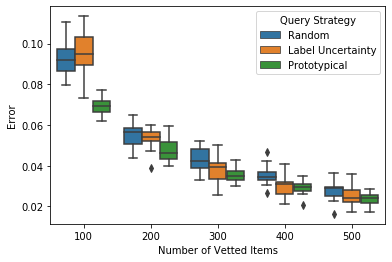

In [9]:
sns.boxplot(hue='Query Strategy',y='Error',x='Number of Vetted Items',data=dataframe)